# Grid the water column Sv MBES data
This notebook was run for each MBES dataset and executes following steps:
* It configures the Dask scheduler to run on the local machine
* It generates a 3D (XYZ) grid from the MBES pointcloud data in Entwine
* It saves the grid to a netCDF file
* It plots cross sections of the grid for visual inspection

In [1]:
import xarray as xr
import os
from math import ceil, floor
from glob import glob
import matplotlib.pyplot as plt

## Run the custom python code so that it is available to the dask workers

In [2]:
%run timbers_code/extract_and_model.py

## Set the parameters
* entwine_path: path to the MBES dataset in Entwine Point Cloud format
* origin_file: this can either be None, in which case the full dataset is gridded, or the name of a MBES line to only grid a subset
* minx, maxx, miny, maxy, minz, maxz: these are the bounds of the MBES point cloud, which is read from Entwine
* z_levels: the z coordinate (depth) intervals at which a slice of the MBES point cloud is extracted prior to gridding. This determines the height of the cylinder, centered on the grid cell center, in which the x_dimension measurements are aggregated to determine the value of the grid cell (i.e. the z resolution of the grid cells).
* radius: the radius of the cylinder, centered on the grid cell center, in which the x_dimension measurements are aggregated to determine the value of the grid cell. See radius in [pdal documentation](https://pdal.io/en/latest/stages/writers.gdal.html). We set this equal to the radius of the optimal linear regression model.
* raster_resolution: The x an y resolution of the grid. See resolution in [pdal documentation](https://pdal.io/en/latest/stages/writers.gdal.html).
* x_dimension: the header of the variable in the MBES point cloud to be gridded (Sv)
* x_dimension_statistic: statistic of the x_dimension of the measurement within the cylinder, centered on the grid cell center, that determines the value of the grid cell
* tmp_raster_path: file path where temporary files will be stores
* output_raster_file: path where the grid will be saved as netCDF file

In [3]:
# data input
entwine_path = "data/Multiingest_0095_6565_21160"
origin_file = None #'0001_20201005_080301' # None = full campaign
# gridding parameters
minx, maxx, miny, maxy, minz, maxz = get_raster_bounds(entwine_path)
# generate z_levels within the z bounds
z_levels = pd.interval_range(floor(minz)-0.5, ceil(maxz)+0.5)
radius = 5 # radius used for gridding
raster_resolution = 2 # resolution of raster
# model parameters
x_dimension = 'value_db'
x_dimension_statistic = 'mean'
# output
tmp_raster_path = 'data/tmp'
output_raster_file = 'data/gridding/grid_{}_{}_{}.nc'.format(os.path.basename(entwine_path),x_dimension_statistic,x_dimension)

## Set the cluster settings

In [4]:
from dask.distributed import LocalCluster
# when running on local machine
cluster = LocalCluster() 

In [5]:
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65229,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.82 GiB
Comm: tcp://127.0.0.1:65267,Total threads: 3
Dashboard: http://127.0.0.1:65268/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:65233,


## Generate the grid files 

In [6]:
%%time
raster = generate_raster_stack(entwine_path = entwine_path,
                             minx = minx, maxx = maxx,
                             miny = miny, maxy = maxy,
                             minz = minz, maxz = maxz,
                             z_levels = z_levels,
                             dimension = x_dimension,
                             statistic = x_dimension_statistic,
                             radius = radius,
                             raster_resolution = raster_resolution,
                             origin_file = origin_file,
                             tmp_raster_path = tmp_raster_path)
raster

Wall time: 1h 42min 18s


<xarray.Dataset>
Dimensions:        (x: 516, y: 772, z: 28)
Coordinates:
  * x              (x) float64 4.73e+05 4.73e+05 4.73e+05 ... 4.74e+05 4.74e+05
  * y              (y) float64 5.682e+06 5.682e+06 ... 5.681e+06 5.681e+06
    spatial_ref    int32 0
  * z              (z) float64 -27.0 -26.0 -25.0 -24.0 ... -3.0 -2.0 -1.0 0.0
Data variables:
    mean_value_db  (z, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

## Save grid as a netCDF file

In [7]:
raster.to_netcdf(output_raster_file)

## Plot grid cross sections for verification

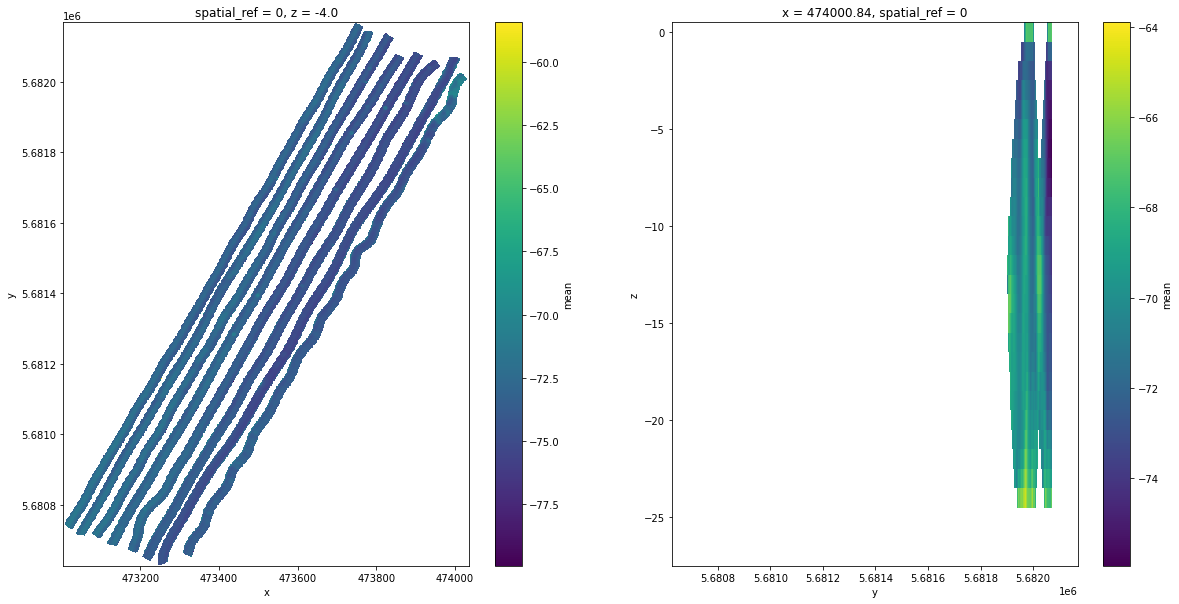

In [8]:
fig,ax = plt.subplots(1, 2,figsize = (20,10))
raster[x_dimension_statistic+'_'+x_dimension].sel(z = -4, method = 'nearest').plot(ax = ax[0])
raster[x_dimension_statistic+'_'+x_dimension].sel(x= 474000, method = "nearest").plot(ax = ax[1])

## Clear out the temporary raster files

In [11]:
del raster
[os.remove(file) for file in glob(os.path.join(tmp_raster_path, '*.tif'))]

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'data/tmp\\6cfe2aba-e76d-460b-ba2a-5af8f45fb36a.tif'